In [100]:
import matplotlib.pyplot as plt
import numpy as np
from DM_phase import get_dm 
import beam_model
from beam_model.utils import get_equatorial_from_position, get_position_from_equatorial
import scipy
from IPython.display import Markdown, display
from matplotlib.colors import LogNorm
from iautils.frbps import frbps_fit, frbps_plot
from iautils import mcmc
from glob import glob
import os
import corner
from sklearn.neighbors import KernelDensity
import emcee
from IPython.display import display, Math
import corner
import seaborn as sns
from multiprocessing import Pool
import statsmodels.api as sm
from scipy.optimize import curve_fit
from matplotlib import gridspec
from scipy.signal import savgol_filter, find_peaks

%matplotlib inline

In [101]:
# Function definitions

def get_waterfall(power,freq, profile2=None, both=False, peaks=None, c=4, ds=None):
    if len(power.shape) > 2:
        snr = []
        for i in range(power.shape[1]):
            snr.append(np.nanmax(get_profile(power[:,i,:])))
        #Pick brightest beam:
        wfall = power[:,np.where(snr == np.nanmax(snr))[0][0],:]
    else:
        wfall = power.copy()
    
    profile = get_profile(power)
    mean, std = np.nanmean(wfall), np.nanstd(wfall)
    fig, (ax1, ax2) = plt.subplots(nrows = 2,ncols = 1, sharex = True, figsize = (12,12), gridspec_kw={'height_ratios':[1,4],'hspace':0})
    if ds is not None:
        im2 = ax2.imshow(wfall, cmap="viridis", origin="upper", aspect="auto", interpolation="nearest",extent=[0,power.shape[-1]*ds, freq[0], freq[-1]], vmin = mean-c*std, vmax = mean+c*std)    
    else:
        im2 = ax2.imshow(wfall, cmap="viridis", origin="upper", aspect="auto", interpolation="nearest",extent=[0,power.shape[-1], freq[0], freq[-1]], vmin = mean-c*std, vmax = mean+c*std)
    if both:
        if ds is not None: 
            im1 = ax1.plot(np.arange(len(profile))*ds, profile, color = 'k', alpha = 0.3, lw = 4)
            ax1.plot(np.arange(len(profile))*ds, profile2, color = 'r')
        else: 
            im1 = ax1.plot(profile, color = 'k', alpha = 0.3, lw = 4)
            ax1.plot(profile2, color = 'r')
    else:
        if ds is not None:
            im1 = ax1.plot(np.arange(len(profile))*ds, profile, color = 'k')
        else:
            im1 = ax1.plot(profile, color = 'k')
    if peaks is not None:
        if ds is not None:
            peaks = peaks * ds
        for peak in peaks:
            ax1.axvline(peak, color = 'r', ls = '--')
            #ax2.axvline(peak, color = 'r', ls = '--')
    
    ax2.set_xlabel('Time (ms)', fontsize = 20)
    ax2.set_ylabel('Frequency (MHz)', fontsize = 20)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im2, cax=cbar_ax)
    plt.show()
    
def exponorm(x,lam,mu,sigma):
    I = lam/2*np.exp(lam/2*(2*mu + lam*sigma**2 - 2*x))
    II = scipy.special.erfc((mu + lam*sigma**2 - x)/(2**0.5 * sigma))
    return I * II

def exponorm_max(mu, lam, sigma):
    tau = 1/lam
    return mu + np.sqrt(2)*sigma*scipy.special.erfcinv(tau/sigma * np.sqrt(2/np.pi)) + sigma**2/tau


def sum_emg(x,*args):
    #args are a1,mu1,sigma1, a2, mu2, sigma2, etc.
    if type(args) != list:
        args = np.array(args).flatten()
        args = list(args)
    scat = args.pop(-1)
    args = np.array(args).flatten()
    num_g = int(len(args)/3)
    args = args.reshape((num_g,3))
    a,mu,sigma = args[...,0], args[...,1], args[...,2]
    gaussian = np.zeros(len(x))
    for i in range(num_g):
        gaussian += a[i]*exponorm(x,scat, mu[i] ,sigma[i])
    return gaussian


def sum_emg_fix(x,*args):
    #args are a1,mu1,sigma1, a2, mu2, sigma2, etc.
    if type(args) != list:
        args = np.array(args).flatten()
        args = list(args)
    scat = args.pop(-1)
    sigma = args.pop(-1)
    args = np.array(args).flatten()
    num_g = int(len(args)/2)
    args = args.reshape((num_g,2))
    a,mu = args[...,0], args[...,1]
    gaussian = np.zeros(len(x))
    for i in range(num_g):
        gaussian += a[i]*exponorm(x,scat, mu[i] ,sigma)
    return gaussian

def sum_gaussian(x,*args):
    #args are a1,mu1,sigma1, a2, mu2, sigma2, etc.
    if type(args) != list:
        args = np.array(args).flatten()
        args = list(args)
    args = np.array(args).flatten()
    num_g = int(len(args)/3)
    args = args.reshape((num_g,3))
    a,mu,sigma = args[...,0], args[...,1], args[...,2]
    gaussian = np.zeros(len(x))
    for i in range(num_g):
        gaussian += a[i]*scipy.stats.norm.pdf(x, mu[i] ,sigma[i])
    return gaussian

#Peak model: chi + gaussian

def fit_gaussian(profile, peaks, model='free',ds=1, IC=None, bounds=False,diagnostic_plots=True):
    if IC is None:
        ICs = []
        peaks = np.array(peaks)
        ub = []
        lb = []
        if model == 'emg_free':
            mu_max = peaks + np.mean(np.diff(peaks))
            mu_min = peaks - np.mean(np.diff(peaks))
            amp_ics = []
            for i in range(len(peaks)-1):
                if i == 0:
                    amp_ics.extend([max(profile[0:int(np.floor(peaks[i] / ds))])])
                    amp_ics.extend([max(profile[int(np.floor(peaks[i] / ds)):int(np.floor(peaks[i+1] / ds))])])
                else:
                    amp_ics.extend([max(profile[int(np.floor(peaks[i] / ds)):int(np.floor(peaks[i+1] / ds))])])
            for i in range(len(peaks)):
                ICs.extend([ds*profile[int(np.floor(peaks[i] / ds))], peaks[i], ds])
                ub.extend([np.inf,mu_max[i], 20])
                lb.extend([0,mu_min[i], 0])
            #scattering tail is the same for all peaks
            ICs.extend([0.004])
            ub.extend([0.5])
            lb.extend([0])
            f = sum_emg
        elif model == 'emg_fixed':
            for i in range(len(peaks)):
                ICs.extend([ds*profile[int(np.floor(peaks[i] / ds))]])
                ub.extend([np.inf,min(peaks[i] + ds*80,len(profile)*ds)])
                lb.extend([0,max(peaks[i] - ds*80,0)])
            #scattering tail + sigma is the same for all peaks
            ICs.extend([ds*1,1/ds])
            ub.extend([np.inf, np.inf])
            lb.extend([0,0])
            f = sum_emg_fix
        elif model == 'gaussian_free':
            for i in range(len(peaks)):
                ICs.extend([ds*profile[int(np.floor(peaks[i] / ds))], peaks[i], 1*ds])
                ub.extend([np.inf,min(peaks[i] + ds*80,len(profile)*ds), np.inf])
                lb.extend([0,max(peaks[i] - ds*80,0), 0])
            f = sum_gaussian
    else:
        IC = np.ravel(IC)
        ICs = []
        for i in range(IC.shape[0]):
            ICs.extend(list(IC[i].ravel()))
        if model == 'emg_free':
            f = sum_emg
        elif model == 'emg_fixed':
            f = sum_emg_fix
        elif model == 'gaussian_free':
            f = sum_gaussian
    x = ds*np.arange(len(profile))
    y= profile
    plt.plot(x,y)
    for p in peaks:
        plt.axvline(p, color = 'r')
    plt.plot(x,f(x,ICs),color = 'orange')
    plt.show()
    #In case some amplitudes are negative by accident
    ICs = abs(np.array(ICs))
    if type(bounds) == bool:
        if not bounds:
            popt,pcov = curve_fit(f,x, y, p0=ICs,maxfev = 100000000)
        else:
            popt,pcov = curve_fit(f,x, y, p0=ICs, bounds = (lb, ub),maxfev = 100000000)
    else:
        popt,pcov = curve_fit(f,x, y, p0=ICs, bounds = (bounds[0], bounds[1]),maxfev = 100000000)
    if model == 'emg_free':
        ret, scat = popt[:-1], popt[-1]
        ret = [ret.reshape((len(peaks), 3)), np.array([scat])]
        ret_e, scat_e = np.sqrt(np.diag(pcov))[:-1], np.sqrt(np.diag(pcov))[-1]
        ret_e = [ret_e.reshape((len(peaks), 3)), np.array([scat_e])]
    elif model == 'emg_fixed':
        ret, sigma, scat = popt[:-2], popt[-2], popt[-1]
        ret = [ret.reshape((len(peaks), 2)), np.array([sigma,scat])]
        ret_e, sigma_e, scat_e = np.sqrt(np.diag(pcov))[:-2], np.sqrt(np.diag(pcov))[-2], np.sqrt(np.diag(pcov))[-1]
        ret_e = [ret_e.reshape((len(peaks), 2)), np.array([sigma_e, scat_e])]
    elif model == 'gaussian_free':
        ret = popt.reshape((len(peaks), 3))
        ret_e = np.sqrt(np.diag(pcov))
        ret_e = ret_e.reshape((len(peaks), 3))
    if diagnostic_plots:
        print('curve_fit params: ', popt)
        fit = f(x,popt)
        plt.figure(figsize= (12,11))
        plt.plot(x, profile, color = 'k', alpha = 0.3, lw = 4, label = 'Data')
        plt.plot(x, fit, color = 'r', label = 'Fit')
        chisqr = reduced_chisq(profile,f(x,popt),len(peaks)*3+1)
        plt.title('Reduced Chi Squared is '+ str(round(chisqr,3)), fontsize = 20)
        plt.ylabel('Power (arb.)', fontsize = 20)
        plt.xlabel('Time (ms)', fontsize = 20)
        plt.legend(fontsize = 20)

        mean = [popt[3*i+1] for i in range(len(peaks))]
        for m in mean:
             plt.axvline(m, color = 'r', ls = '--')  
        plt.xlabel('Time (ms)', fontsize = 20)
        plt.show()
        
        #residuals:
        plt.figure(figsize = (12,10))
        plt.title('Residuals', fontsize = 20)
        residuals = profile-fit
        plt.scatter(np.arange(len(profile))*ds,residuals, color = 'k')
        plt.ylabel('Residuals',fontsize = 20)
        plt.xlabel('Time (ms)', fontsize = 20)
        plt.axhline(0,color = 'r')
        plt.show()

        #QQ plot
        #create Q-Q plot with 45-degree line added to plot
        fig = sm.qqplot(residuals, line='45')
        plt.show()
    #The diagonals provide the variance of the parameter estimate. 
    #Compute one standard deviation errors on the parameters: 
    return fit, ret, ret_e, pcov

def reduced_chisq(data,fit,pars):
    return sum((data-fit)**2)/(len(data)-pars)
 
def make_mk_table(popt,popt_e,model,evt):
    evt_id = evt.split('/')
    if len(evt_id) > 5:
        evt_id = evt_id[5]
    else:
        evt_id = evt
    
    display(Markdown("## Raw Fit Parameters for Event " + str(evt_id)))
    
    if model == 'emg_free':
        npeaks = int(len(popt[:-1])/3)
        peak_params = np.array(popt[:-1]).reshape((npeaks, 3))
        peak_params_e = np.array(popt_e[:-1]).reshape((npeaks, 3,2))
        peak_params,peak_params_e = peak_params[peak_params[...,1].argsort()], peak_params_e[peak_params[...,1].argsort()]
        
        table_rows = [
        "| Peak Number | Amplitude  |$\mu$ (ms) | $\sigma$ (ms) |\n| :-----: | :-----: | :-----: |  :-----:  |"
        ]
        for i in range(npeaks):
            table_rows.append(
                "| " + str(i+1)+ " | "+ "$"+str(round(peak_params[i,0],3)) + "^{+" + str(round(peak_params_e[i,0][1],3)) + "}_{-" + str(round(peak_params_e[i,0][0],3)) + "} $|"
                +"$"+str(round(peak_params[i,1],3)) + "^{+" + str(round(peak_params_e[i,1][1],3)) + "}_{-" + str(round(peak_params_e[i,1][0],3)) + "} $|"
                +"$"+str(round(peak_params[i,2],3)) + "^{+" + str(round(peak_params_e[i,2][1],3)) + "}_{-" + str(round(peak_params_e[i,2][0],3)) + "} $|"
                )
        display(Markdown("\n".join(table_rows)))
        display(Markdown('Scattering rate: $\lambda: ' + str(round(popt[-1],5)) + ' ^ {+' + str(round(popt_e[-1][1],5)) + '}_{-' + str(round(popt_e[-1][0],5)) + '}$'))
        
        display(Markdown("## TOAs"))

    elif model == 'emg_fixed':
        npeaks = popt[0].shape[0]
        popt[0] = popt[0][popt[0][...,1].argsort()]
        popt_e[0] = popt_e[0][popt[0][...,1].argsort()]
        table_rows = [
        "| Peak Number | Amplitude |  $\delta$ Amplitude | $\mu$ (ms) | $\delta \mu$ |\n| :-----: | :-----: |  :-----: |  :-----: | :-----: |"
        ]
        for i in range(npeaks):
            table_rows.append(
                "| {:d} | {:.3f} | {:.3f} | {:.3f} | {:.3f} |".format(
                    i+1, popt[0][i][0], popt_e[0][i][0], popt[0][i][1], popt_e[0][i][1]
                )
            ) 
        display(Markdown("\n".join(table_rows)))
        display(Markdown('Scattering timescale $t = 1/\lambda$: ' + str(round(1/popt[-1][0],3)) + ' $\pm$ ' + str(round(popt_e[-1][0]/popt[-1][0],3))))        
        display(Markdown("## TOAs"))
        display(Markdown("We calculate relative TOAs using only the mean $\mu$ of the Gaussian since both the pulse width and scattering shape parameter are fixed for every peak:"))
        display(Markdown("Convert to relative TOA: TOA (ms) = ($\mu-\mu_0$) $\pm \Delta \mu$ "))
        mean = popt[0][...,1]
        mean_err = popt_e[0][...,1]
    
    elif model == 'gaussian_free':
        npeaks = popt.shape[0]
        popt = popt[popt[...,1].argsort()]
        popt_e = popt_e[popt[...,1].argsort()]
        table_rows = [
        "| Peak Number | Amplitude | $\delta$ Amplitude |$\mu$ (ms) | $\delta \mu$ | $\sigma$ (ms)| $\delta \sigma$ |\n| :-----: | :-----: | :-----: |  :-----: |  :-----: |  :-----: | :-----: |"
        ]
        for i in range(npeaks):
            table_rows.append(
                "| {:d} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} |".format(
                i+1, popt[i,0], popt_e[i,0], popt[i,1], popt_e[i,1], popt[i,2], popt_e[i,2]
                )
            )
        display(Markdown("\n".join(table_rows)))
        mean = popt[...,1]

        #Error Prop
        #mean_err = sqrt( mu_err**2 + (lam_err/lam)**2) 
        mean_err = popt_e[...,1]
        
        display(Markdown("## TOAs"))
        display(Markdown("We calculate relative TOAs using the mean of the Gaussian:"))
    
    table_rows = [
        "| Peak Number | TOA (ms)|\n| :-----: | :-----: |"
    ]
    for i in range(npeaks):
        table_rows.append(
             "| " + str(i+1)+ " | "+ "$"+str(round(peak_params[i,1] - peak_params[0,1],3)) + "^{+" + str(round(peak_params_e[i,1][1],3)) + "}_{-" + str(round(peak_params_e[i,1][0],3)) + "} $|"
        )
    display(Markdown("\n".join(table_rows)))
    
    
def smoothing_combs(profile, factor, maxw=None, maxp=6, diagnostic_plots=True):
    # Using max window, smooth over all valid combinations
    if maxw is None:
        maxw = 80*8 / factor
        if maxw/2 % 1 == 0:
            maxw += 1
    #Keep combinations that return between 5 and 18 peaks
    window = np.arange(1,maxw,2, dtype=int)
    poly = np.linspace(1,maxp,maxp,dtype=int)
    num_peaks_test = []
    x = []
    y = []
    peaks_loc = []
    for w in window:
        for p in poly:
            if p + 10*p< w:
                nice_profile = savgol_filter(profile, w,p)
                peaks_test = find_peaks(nice_profile, height = 0.4, width = 30)[0]
                #for factor = 1, height = 0.4, width = 30
                if len(peaks_test) >= 5 and len(peaks_test) <= 15 and np.max(nice_profile) > 1:
                    num_peaks_test.append(len(peaks_test))
                    peaks_loc.append(np.array(peaks_test))
                    x.append(w)
                    y.append(p)
    
    if diagnostic_plots:  
        plt.figure(figsize = (12,10))
        plt.scatter(x,y, c = num_peaks_test)
        plt.xlabel('Window', fontsize = 20)
        plt.ylabel('Polyorder', fontsize = 20)
        num_peaks_test = np.array(num_peaks_test)
        print('Number of valid combinations: ', len(num_peaks_test))
        plt.colorbar()
        plt.show()

    return num_peaks_test, peaks_loc

def return_num_peaks(profile, N, t_res, num_peaks_test = None, peaks_loc = None, maxp=6, ub = 4130, d=17,diagnostic_plots=True):
    if num_peaks_test is None:
        num_peaks_test, peaks_loc = smoothing_combs(profile, maxp=maxp, diagnostic_plots=diagnostic_plots)
        
    temp = []
    for i in range(len(num_peaks_test)):
        if num_peaks_test[i] == N:
            temp.extend(peaks_loc[i])
    
    # KDE Estimation    
    X = np.array(t_res*np.array(temp)).reshape(-1, 1)
    b = np.linspace(0.01,1000,10000)
    n_p = N+1
    i = 0
    s = np.linspace(400,ub,400)
    while n_p > N:
        kde = KernelDensity(kernel='exponential', bandwidth=b[i]).fit(X)
        e = kde.score_samples(s.reshape(-1,1))
        ma = find_peaks(e, distance=d)[0]
        n_p = len(ma)
        i += 1
        if len(ma) == N:
            plt.plot(s,e, color = 'r')
            clusters = s[ma]
            for cluster in clusters:
                plt.axvline(cluster, color = 'lime')
            print(b[i], clusters,ma)
            
    if diagnostic_plots:
        plt.figure(figsize = (12,10))
        h = plt.hist(t_res*np.array(temp), bins = t_res*np.linspace(0,len(profile),100), color = 'b')
        bins = np.diff(h[1])/2. + h[1][:-1]
        plt.plot(np.arange(len(profile))*t_res, max(h[0])* profile / profile.max(), color = 'k', alpha = 0.3, lw = 4)     
        u = clusters + np.mean(np.diff(clusters))/2
        l = clusters - np.mean(np.diff(clusters))/2
        for i in range(len(clusters)):
            plt.axvline(u[i], color = 'b')
            plt.axvline(l[i], color = 'r')
            plt.axvline(clusters[i], color = 'lime')
        plt.xlabel('Time (ms)',fontsize = 20)
        plt.title(str(N) + ' peaks',fontsize = 20)
        plt.show()
    return clusters

def plot_chain(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""
  
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 16), np.percentile(param, 84)
  
    # Plotting
    plt.figure(figsize = (12,10))
    plt.subplot(2,1,1)
    plt.plot(param, color = 'k')
    plt.xlabel('Samples', fontsize = 18)
    plt.ylabel(param_name, fontsize = 18)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    plt.title(r'Trace and Posterior Distribution for '+ param_name, fontsize = 18)

    plt.subplot(2,1,2)
    plt.hist(param, 30, density=True,color = 'k'); sns.kdeplot(param, shade=True, color='b')
    plt.xlabel(param_name, fontsize = 18)
    plt.ylabel('Density', fontsize = 18)
    plt.axvline(mean, color='r', lw=2, linestyle='--',label='Mean')
    plt.axvline(median, color='purple', lw=2, linestyle='--',label='Median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.3, label='68% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.3)
  
    plt.gcf().tight_layout()
    plt.legend()

In [ ]:
# FRB 20191221A

In [93]:
#Load data and normalize
event_id = '65777546'
(
    _,
    profile,
    t_res,
) = np.load(f'data/{event_id}_data.npz').values()

Number of valid combinations:  1280


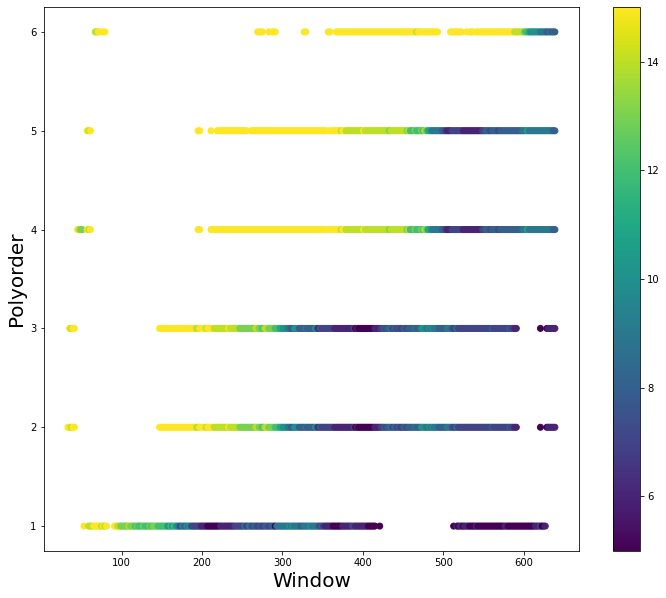

184.42659765976595 [ 643.05764411 1297.44360902 1718.12030075 2148.14536341 2353.80952381
 2568.82205514 2765.13784461 2924.06015038 3232.55639098 3709.32330827
 3924.3358396 ] [ 26  96 141 187 209 232 253 270 303 354 377]


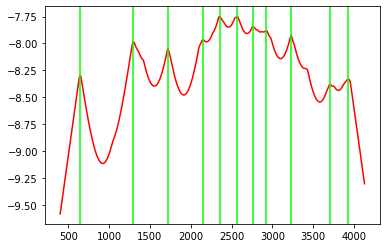

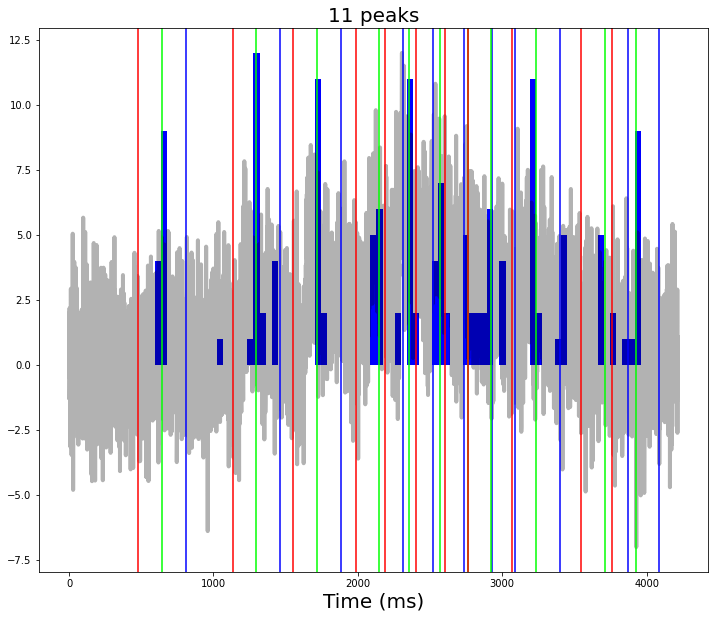

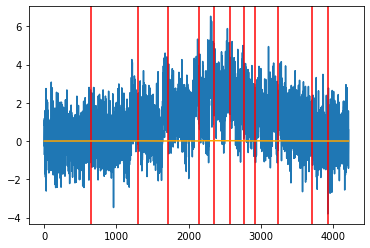

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in multiply


curve_fit params:  [1.67088737e+02 5.55493016e+02 2.59031178e-01 4.84200839e+02
 1.20191336e+03 1.01713619e+01 6.84095806e+02 1.64088758e+03
 1.68765345e+00 6.98154843e+02 2.07244402e+03 1.01623985e+01
 7.22020040e+02 2.29117419e+03 3.29259375e+00 4.65299795e+02
 2.50617978e+03 1.96123146e+00 2.96517039e+02 2.72485206e+03
 1.22523851e+00 1.90132291e+02 2.94268605e+03 1.67288641e-01
 3.49292403e+02 3.16031877e+03 7.08443324e-01 6.72314411e+01
 3.65916035e+03 1.26630037e+01 7.22763160e+01 3.90216669e+03
 1.90568661e-01 3.70458262e-03]


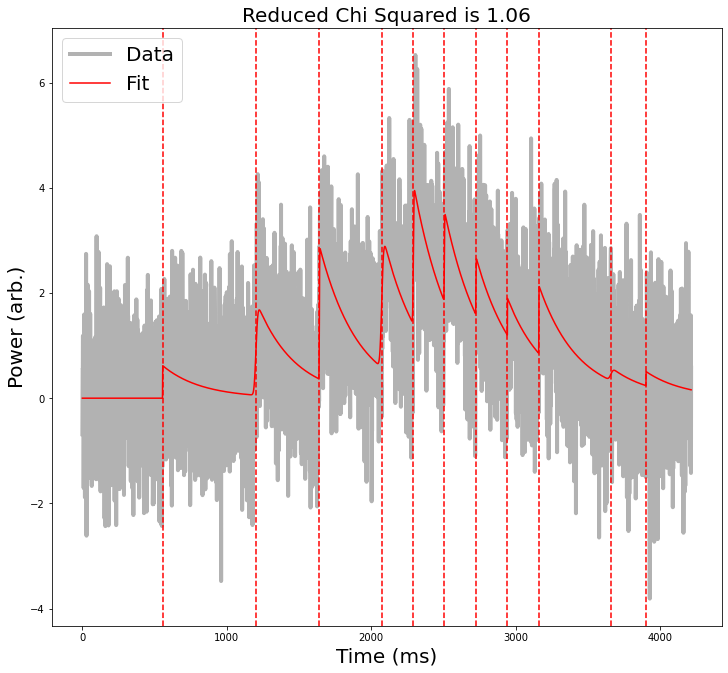

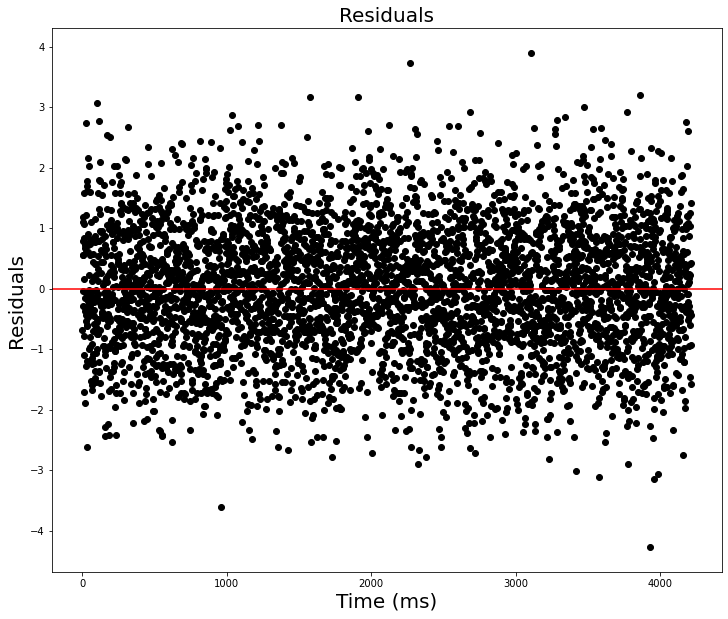

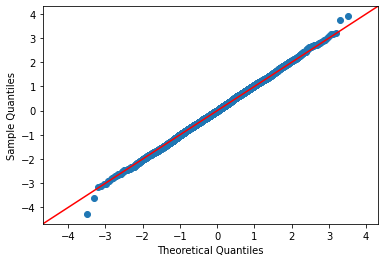

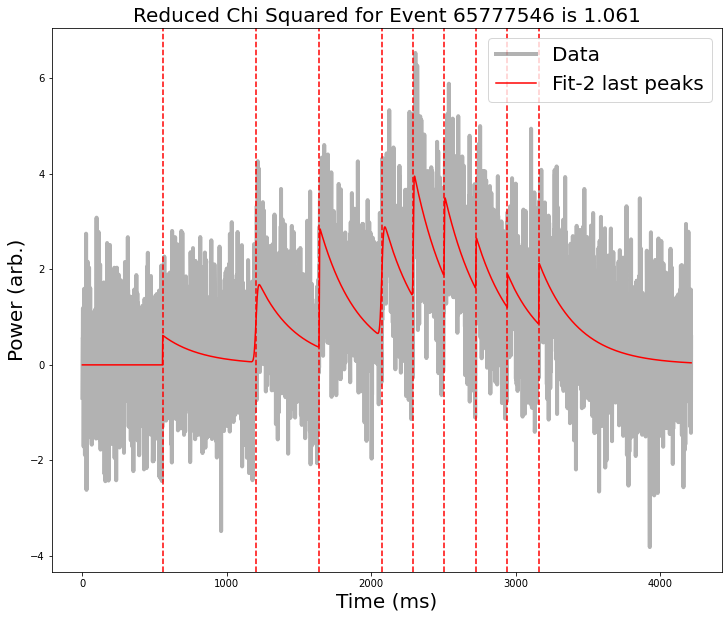

(9, 3)


In [5]:
# To calculate the reduced chi-square for a different number of peaks, change this parameter
number_of_peaks = 9

num_peaks_test, peaks_loc = smoothing_combs(profile, factor)
peaks = return_num_peaks(profile, number_of_peaks + 2, t_res, num_peaks_test = num_peaks_test, peaks_loc = peaks_loc)
fit, popt, popt_e,pcov = fit_gaussian(profile, peaks, model='emg_free', ds=t_res,bounds=True)

plt.figure(figsize = (12,10))
plt.plot(np.arange(len(profile))*t_res, profile, color = 'k', alpha = 0.3, lw = 4, label = 'Data')
newfit = sum_emg(np.arange(len(profile))*t_res,np.append(np.ravel(popt[0][:-2,...]),popt[-1]))
plt.plot(np.arange(len(profile))*t_res, newfit, color = 'r', label = 'Fit-2 last peaks')
for p in popt[0][...,1][:-2]:
    plt.axvline(p,color= 'r', ls = '--')
plt.legend(fontsize = 20)
chisqr = reduced_chisq(profile,newfit,13)
plt.title('Reduced Chi Squared for Event ' + event_id +' is '+ str(round(chisqr,3)), fontsize = 20)
plt.xlabel('Time (ms)', fontsize = 20)
plt.ylabel('Power (arb.)', fontsize = 20)
plt.show()
popt[0] = popt[0][:-2,...]
print(popt[0].shape)

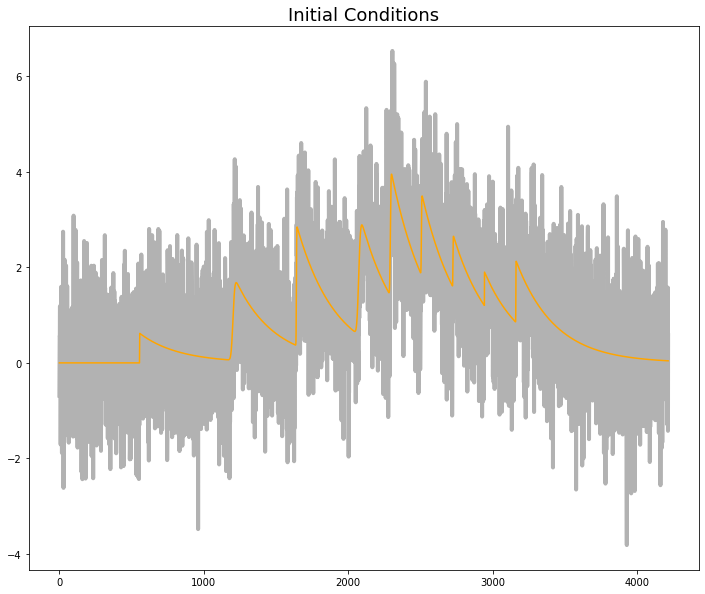

 13%|█▎        | 94024/700000 [30:06<2:46:21, 60.71it/s]

In [ ]:
peaks = popt[0][:,1]
global prior_max
prior_max = popt[0][:,1] + np.mean(np.diff(peaks))/2

global prior_min
prior_min = popt[0][:,1] - np.mean(np.diff(peaks))/2

nchain = 700000
nwalkers=100
global model
model = sum_emg
global x
x = t_res*np.arange(len(profile))


def log_likelihood(parameters):
    n = int(len(parameters[:-1])/3)
    others = parameters[:-1].reshape((n,3))
    if (parameters < 0).any():
        return - np.inf
    elif parameters[-1] > 0.5:
        return - np.inf
    elif (others[:,0] > 1e5).any():
        return - np.inf
    elif (others[:,2] > 50).any():
        return - np.inf
    elif (others[:,1] > prior_max).any() or (others[:,1] < prior_min).any():
        return - np.inf
    else:
        ret = - np.sum((profile - model(x,parameters))**2)
        if np.isnan(ret).all():
            ret = - np.inf
        return ret
        

ndim, nwalkers = len(peaks)*3+1, nwalkers
ics = []
for i in range(len(peaks)):
    ics.extend(popt[0][i])
ics.extend(popt[-1])
plt.figure(figsize = (12,10)) 
plt.title('Initial Conditions', fontsize = 18)
plt.plot(np.arange(len(profile))*t_res, profile, color = 'k', alpha = 0.3, lw = 4, label = 'Data')    
plt.plot(np.arange(len(profile))*t_res, sum_emg(t_res*np.arange(len(profile)),ics), color = 'orange', label = 'Fit') 
plt.show()
initial_walkers = np.random.normal(scale=1e-5, loc = ics, size=(nwalkers, ndim))
with Pool(processes=10) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, pool = pool)
    sampler.run_mcmc(initial_walkers, nchain, progress=True)
    
try:
    tau = sampler.get_autocorr_time()
    dis = int(2*np.mean(tau))
    thin = int(np.mean(tau)/2)
    print(tau)
except Exception as e:
    print(e)
    dis = 10000
    thin = 2500
    print('Discarded ' + str(dis) + ' and thinned by ' + str(thin))
    tau = np.nan
flat_samples = sampler.get_chain(discard=dis, thin=thin, flat=True)
print(flat_samples.shape)
final_pars = []
final_errs = []
for i in range(len(peaks)*3+1):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    final_pars.append(mcmc[1])
    final_errs.append(np.array(q))

labels = []
ls = ['$A_{', '$\mu_{', '$\sigma_{']
b = '}$'
for i in range(len(peaks)):
    labels.extend([l + str(i) + b for l in ls])
    if i == len(peaks)-1:
        labels.extend(['$\lambda$'])

fig = corner.corner(flat_samples, labels=labels, truths=final_pars, truth_color = 'r', show_titles=True, quantiles=[0.16, 0.5, 0.84], title_kwargs={"fontsize": 18})
plt.savefig('corner'+str(len(peaks))+'.png')
plt.show()

fit = sum_emg(t_res*np.arange(len(profile)),final_pars)
chisqr = reduced_chisq(profile,fit,len(peaks)*3+1)
mean = np.array(final_pars[:-1]).reshape((len(peaks),3))[...,1]
plt.figure(figsize = (12,10))
for i in range(len(mean)):
    plt.axvline(mean[i], color = 'r', ls = '--')
plt.plot(t_res*np.arange(len(profile)),profile, label = event_id)
plt.plot(t_res*np.arange(len(profile)),fit, label = 'Fit')
plt.title('Reduced Chi Squared for Event ' + event_id +' is '+ str(round(chisqr,3)), fontsize = 20)
plt.xlabel('Time (ms)', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()
        
#residuals:
plt.figure(figsize = (12,10))
plt.title('Residuals', fontsize = 20)
residuals = profile-fit
plt.scatter(np.arange(len(profile))*t_res,residuals, color = 'k')
plt.ylabel('Residuals',fontsize = 20)
plt.xlabel('Time (ms)', fontsize = 20)
plt.axhline(0,color = 'r')
plt.show()

#QQ plot
#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(residuals, line='45')
plt.show()
        
        
        
#tau, flat_samples, final_pars, final_errs = mcmc(peaks, popt, profile, t_res, nwalkers=max(3*len(peaks)+1,100), nchain=2000000, pool = True)

make_mk_table(final_pars,final_errs,'emg_free','65777546')


In [ ]:
# np.save(f'data/{event_id}_mcmc_chains.npy', flat_samples)

# Note that we have not fixed the random seed and, thus, results may vary slightly

In [ ]:
# FRB 20210206A

In [102]:
#Load data and normalize
event_id = '156410110'
(
    _,
    profile,
    t_res,
) = np.load(f'data/{event_id}_data.npz').values()

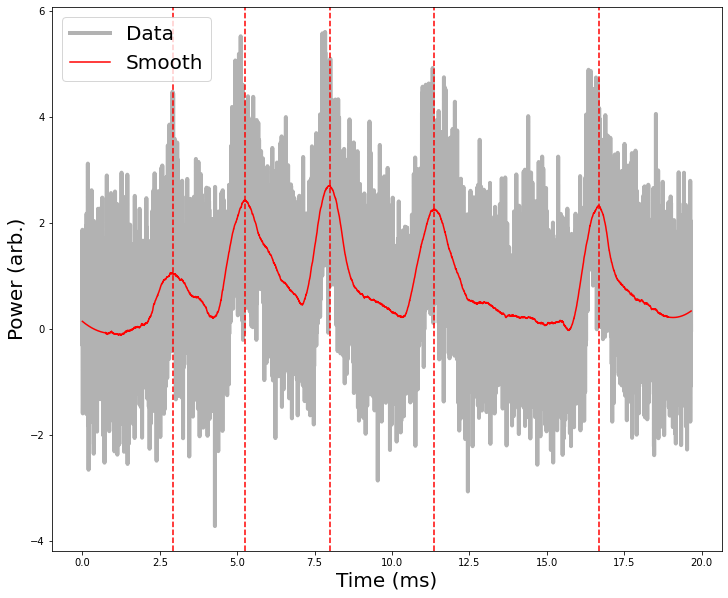

In [103]:
#Smoothing

nice_profile = savgol_filter(profile, 581,2)

peaks = find_peaks(nice_profile, height = 1, width = 20)[0]

plt.figure(figsize = (12,10))
event_id = '156410110'
plt.plot(np.arange(len(profile))*t_res, profile, color = 'k', alpha = 0.3, lw = 4, label = 'Data')
plt.plot(np.arange(len(profile))*t_res, nice_profile, color = 'r', label = 'Smooth')
for p in peaks:
    plt.axvline(p*t_res, color = 'r', ls = '--')
plt.legend(fontsize = 20)
plt.xlabel('Time (ms)', fontsize = 20)
plt.ylabel('Power (arb.)', fontsize = 20)
plt.show()

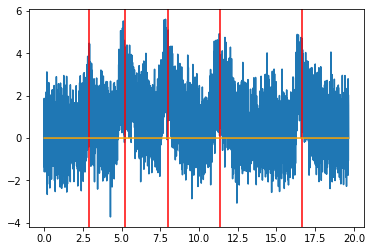

curve_fit params:  [ 2.43688132  2.43334238  0.18417543  4.72777848  4.77097721  0.1041081
  3.58866276  7.5902617   0.07482899  3.50028503 10.88254476  0.09402839
  4.00476171 16.25023612  0.02220371  0.5       ]


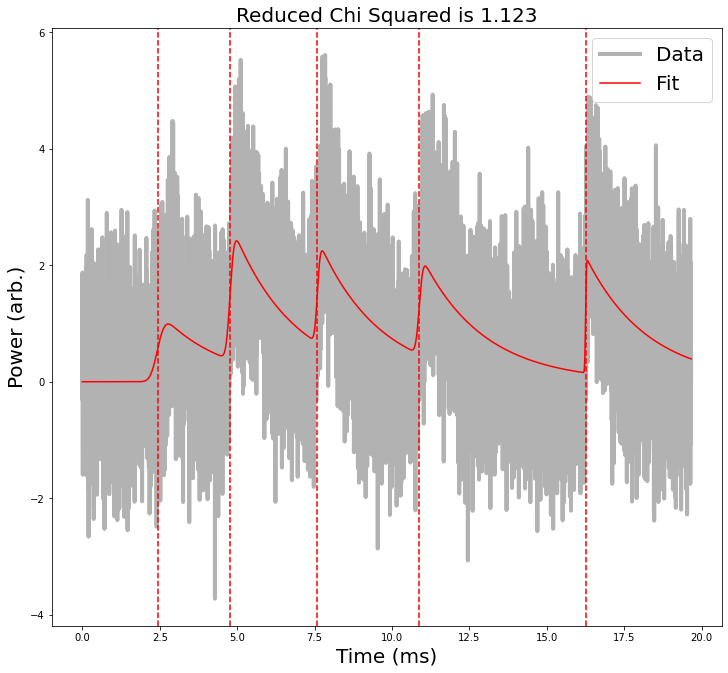

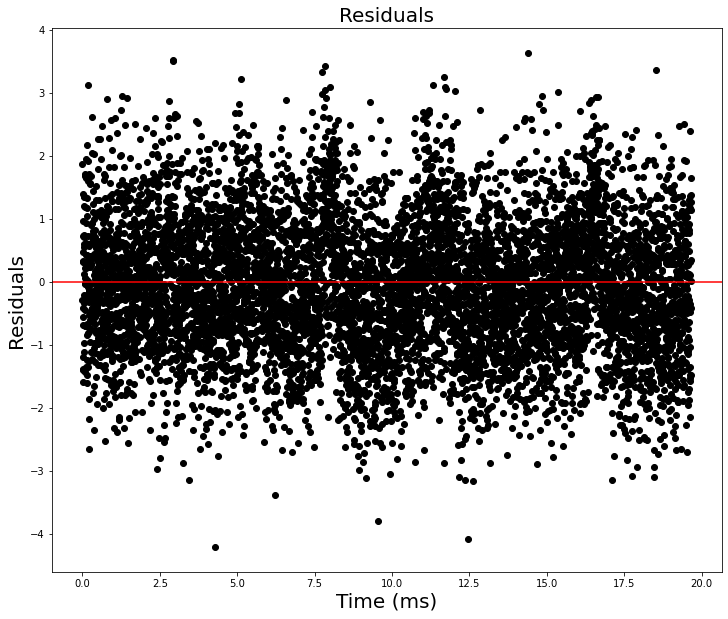

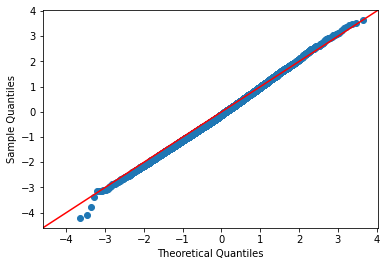

In [104]:
fit, popt, popt_e,pcov = fit_gaussian(profile, t_res*peaks, model='emg_free', ds=t_res, bounds = True)

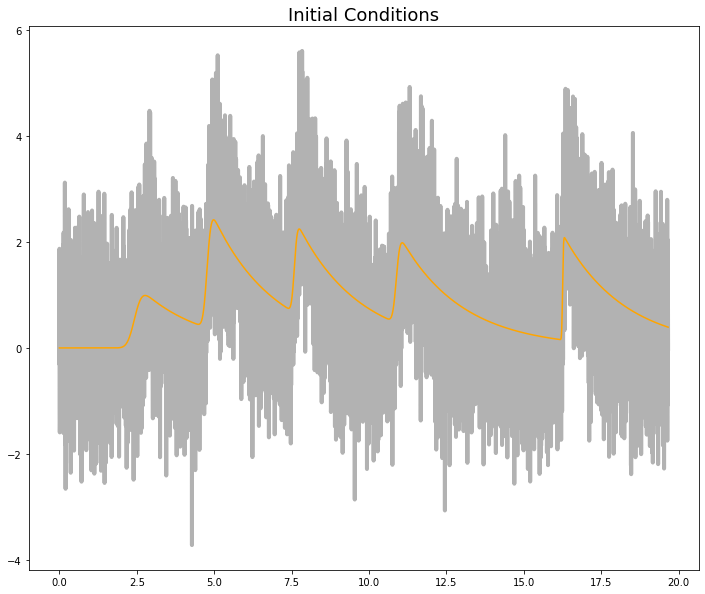

[2022-03-21 22:46:47,034] WARNING You must install the tqdm library to use progress indicators with emcee


In [ ]:
peaks = popt[0][:,1]
global prior_max
prior_max = popt[0][:,1] + np.mean(np.diff(peaks))/2

global prior_min
prior_min = popt[0][:,1] - np.mean(np.diff(peaks))/2

nchain = 500000
nwalkers=100
global model
model = sum_emg
global x
x = t_res*np.arange(len(profile))


def log_likelihood(parameters):
    n = int(len(parameters[:-1])/3)
    others = parameters[:-1].reshape((n,3))
    if (parameters < 0).any():
        return - np.inf
    elif parameters[-1] > 1.5:
        return - np.inf
    elif (others[:,0] > 1e5).any():
        return - np.inf
    elif (others[:,2] > 1e3).any():
        return - np.inf
    elif (others[:,1] > prior_max).any() or (others[:,1] < prior_min).any():
        return - np.inf
    else:
        ret = - np.sum((profile - model(x,parameters))**2)
        if np.isnan(ret).all():
            ret = - np.inf
        return ret
        

ndim, nwalkers = len(peaks)*3+1, nwalkers
ics = []
for i in range(len(peaks)):
    ics.extend(popt[0][i])
ics.extend(popt[-1])
plt.figure(figsize = (12,10)) 
plt.title('Initial Conditions', fontsize = 18)
plt.plot(np.arange(len(profile))*t_res, profile, color = 'k', alpha = 0.3, lw = 4, label = 'Data')    
plt.plot(np.arange(len(profile))*t_res, sum_emg(t_res*np.arange(len(profile)),ics), color = 'orange', label = 'Fit') 
plt.show()
initial_walkers = np.random.normal(scale=1e-10, loc = ics, size=(nwalkers, ndim))
with Pool(processes=10) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, pool = pool)
    sampler.run_mcmc(initial_walkers, nchain, progress=True)
    
try:
    tau = sampler.get_autocorr_time()
    dis = int(2*np.mean(tau))
    thin = int(np.mean(tau)/2)
    print(tau)
except Exception as e:
    print(e)
    dis = 100000
    thin = 25000
    print('Discarded ' + str(dis) + ' and thinned by ' + str(thin))
    tau = np.nan
flat_samples = sampler.get_chain(discard=dis, thin=thin, flat=True)
print(flat_samples.shape)
final_pars = []
final_errs = []
for i in range(len(peaks)*3+1):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    final_pars.append(mcmc[1])
    final_errs.append(np.array(q))

labels = []
ls = ['$A_{', '$\mu_{', '$\sigma_{']
b = '}$'
for i in range(len(peaks)):
    labels.extend([l + str(i) + b for l in ls])
    if i == len(peaks)-1:
        labels.extend(['$\lambda$'])

fig = corner.corner(flat_samples, labels=labels, truths=final_pars, truth_color = 'r', show_titles=True, quantiles=[0.16, 0.5, 0.84], title_kwargs={"fontsize": 18})
plt.savefig('156410110_corner'+str(len(peaks))+'.png')
plt.show()

fit = sum_emg(t_res*np.arange(len(profile)),final_pars)
chisqr = reduced_chisq(profile,fit,len(peaks)*3+1)
mean = np.array(final_pars[:-1]).reshape((len(peaks),3))[...,1]
plt.figure(figsize = (12,10))
plt.plot(t_res*np.arange(len(profile)),profile, label = event_id)
plt.plot(t_res*np.arange(len(profile)),fit, label = 'Fit')
for i in range(len(mean)):
    plt.axvline(mean[i], color = 'r', ls = '--')
plt.title('Reduced Chi Squared for Event ' + event_id +' is '+ str(round(chisqr,3)), fontsize = 20)
plt.xlabel('Time (ms)', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()
        
#residuals:
plt.figure(figsize = (12,10))
plt.title('Residuals', fontsize = 20)
residuals = profile-fit
plt.scatter(np.arange(len(profile))*t_res,residuals, color = 'k')
plt.ylabel('Residuals',fontsize = 20)
plt.xlabel('Time (ms)', fontsize = 20)
plt.axhline(0,color = 'r')
plt.show()

#QQ plot
#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(residuals, line='45')
plt.show()
        
        
        
#tau, flat_samples, final_pars, final_errs = mcmc(peaks, popt, profile, t_res, nwalkers=max(3*len(peaks)+1,100), nchain=2000000, pool = True)

make_mk_table(final_pars,final_errs,'emg_free',event_id)

In [ ]:
# np.save(f'data/{event_id}_mcmc_chains.npy', flat_samples)

# Note that we have not fixed the random seed and, thus, results may vary slightly

In [ ]:
# FRB 20210213A

In [ ]:
#Load data and normalize
event_id = '157646917'
(
    _,
    profile,
    t_res,
) = np.load(f'data/{event_id}_data.npz').values()

In [ ]:
#Smoothing

nice_profile = savgol_filter(profile, 101,5)

peaks = find_peaks(nice_profile, height = 0.6, width = 33)[0]

plt.figure(figsize = (12,10))
event_id = '157646917'
plt.plot(np.arange(len(profile))*t_res, profile, color = 'k', alpha = 0.3, lw = 4, label = 'Data')
plt.plot(np.arange(len(profile))*t_res, nice_profile, color = 'r', label = 'Smooth')
#plt.axvspan(0, 1000*t_res, color = 'b', alpha=0.2,label = 'Max Window')
for p in peaks:
    plt.axvline(p*t_res, color = 'r', ls = '--')
plt.legend(fontsize = 20)
plt.xlabel('Time (ms)', fontsize = 20)
plt.ylabel('Power (arb.)', fontsize = 20)
plt.show()

In [ ]:
fit, popt, popt_e,pcov = fit_gaussian(profile, t_res*peaks, model='emg_free', ds=t_res, bounds = True)

In [ ]:
peaks = popt[0][:,1]
global prior_max
prior_max = popt[0][:,1] + np.mean(np.diff(peaks))/4

global prior_min
prior_min = popt[0][:,1] - np.mean(np.diff(peaks))/4

nchain = 500000
nwalkers=100
global model
model = sum_emg
global x
x = t_res*np.arange(len(profile))


def log_likelihood(parameters):
    n = int(len(parameters[:-1])/3)
    others = parameters[:-1].reshape((n,3))
    if (parameters < 0).any():
        return - np.inf
    elif parameters[-1] > 2:
        return - np.inf
    elif (others[:,0] > 1e5).any():
        return - np.inf
    elif (np.array([others[:,2][0],others[:,2][2],others[:,2][3]])> 1).any() or (np.array([others[:,2][1],others[:,2][4],others[:,2][5]]) > 20).any():
        return - np.inf
    elif (others[:,1] > prior_max).any() or (others[:,1] < prior_min).any():
        return - np.inf
    else:
        ret = - np.sum((profile - model(x,parameters))**2)
        if np.isnan(ret).all():
            ret = - np.inf
        return ret
        

ndim, nwalkers = len(peaks)*3+1, nwalkers
ics = []
for i in range(len(peaks)):
    ics.extend(popt[0][i])
ics.extend(popt[-1])
plt.figure(figsize = (12,10)) 
plt.title('Initial Conditions', fontsize = 18)
plt.plot(np.arange(len(profile))*t_res, profile, color = 'k', alpha = 0.3, lw = 4, label = 'Data')    
plt.plot(np.arange(len(profile))*t_res, sum_emg(t_res*np.arange(len(profile)),ics), color = 'orange', label = 'Fit') 
plt.show()
initial_walkers = np.random.normal(scale=1e-10, loc = ics, size=(nwalkers, ndim))
with Pool(processes=15) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, pool = pool)
    sampler.run_mcmc(initial_walkers, nchain, progress=True)
    
try:
    tau = sampler.get_autocorr_time()
    dis = int(2*np.mean(tau))
    thin = int(np.mean(tau)/2)
    print(tau)
except Exception as e:
    print(e)
    dis = 1000
    thin = 500
    print('Discarded ' + str(dis) + ' and thinned by ' + str(thin))
    tau = np.nan
flat_samples = sampler.get_chain(discard=dis, thin=thin, flat=True)
print(flat_samples.shape)
final_pars = []
final_errs = []
for i in range(len(peaks)*3+1):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    final_pars.append(mcmc[1])
    final_errs.append(np.array(q))

labels = []
ls = ['$A_{', '$\mu_{', '$\sigma_{']
b = '}$'
for i in range(len(peaks)):
    labels.extend([l + str(i) + b for l in ls])
    if i == len(peaks)-1:
        labels.extend(['$\lambda$'])

fig = corner.corner(flat_samples, labels=labels, truths=final_pars, truth_color = 'r', show_titles=True, quantiles=[0.16, 0.5, 0.84], title_kwargs={"fontsize": 18})
plt.savefig(event_id + '_corner'+str(len(peaks))+'.png')
plt.show()

fit = sum_emg(t_res*np.arange(len(profile)),final_pars)
chisqr = reduced_chisq(profile,fit,len(peaks)*3+1)
mean = np.array(final_pars[:-1]).reshape((len(peaks),3))[...,1]
plt.figure(figsize = (12,10))
plt.plot(t_res*np.arange(len(profile)),profile, label = event_id)
plt.plot(t_res*np.arange(len(profile)),fit, label = 'Fit')
for i in range(len(mean)):
    plt.axvline(mean[i], color = 'r', ls = '--')
plt.title('Reduced Chi Squared for Event ' + event_id +' is '+ str(round(chisqr,3)), fontsize = 20)
plt.xlabel('Time (ms)', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()
        
#residuals:
plt.figure(figsize = (12,10))
plt.title('Residuals', fontsize = 20)
residuals = profile-fit
plt.scatter(np.arange(len(profile))*t_res,residuals, color = 'k')
plt.ylabel('Residuals',fontsize = 20)
plt.xlabel('Time (ms)', fontsize = 20)
plt.axhline(0,color = 'r')
plt.show()

#QQ plot
#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(residuals, line='45')
plt.show()
        
        
        
#tau, flat_samples, final_pars, final_errs = mcmc(peaks, popt, profile, t_res, nwalkers=max(3*len(peaks)+1,100), nchain=2000000, pool = True)

make_mk_table(final_pars,final_errs,'emg_free',event_id)

In [ ]:
# np.save(f'data/{event_id}_mcmc_chains.npy', flat_samples)

# Note that we have not fixed the random seed and, thus, results may vary slightly